# Matflow Crystal Plasticity Modelling diffraction post-processing examples

A Jupyter notebook with crystal plasticity model post-processing examples.

First, specify the workflow you would like to post-process by changing the path string of the `workflow` variable.

In [1]:

from matflow import load_workflow

# define path to completed matflow workflow directory containing result.hdf5 file...
workflow_dir = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/\
034_Ti64_TIFUN-T4_TD_910C_DeformY64x_1mms-1_Xprism_2023-02-24-161636/"

# use load_workflow to import the result.hdf5 file into jupyter as a variable...
workflow = load_workflow(workflow_dir)
ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response


Loading matflow config from /mnt/iusers01/jf01/y15576gb/.matflow/config.yml
Loading task schemas from 1 file(s)...OK!
Loading software definitions from 1 file(s)...OK!


---
## Plotting Stress-strain of a matflow-DAMASK simulation.
The following code takes a matflow workflow's `workflow.hdf5` file and plots stress against strain.

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }
          opts: { add_Mises: true }

      volume_data: # For global stress-strain
        - field_name: sigma
          transforms: [mean_along_axes: 1] # mean over VE
          out_name: sigma
        - field_name: epsilon_V^0(F)_vM
          transforms: [mean_along_axes: 1] # mean over VE 
          out_name: epsilon_V^0(F)_vM

    base:
      phases:
        phase_1:
          mechanical:
            output: [F, F_e, F_p, P, L_p]
```

In [ ]:
# function help
from plotting import plot_stress_strain
plot_stress_strain? # one question mark for doc, two for whole function

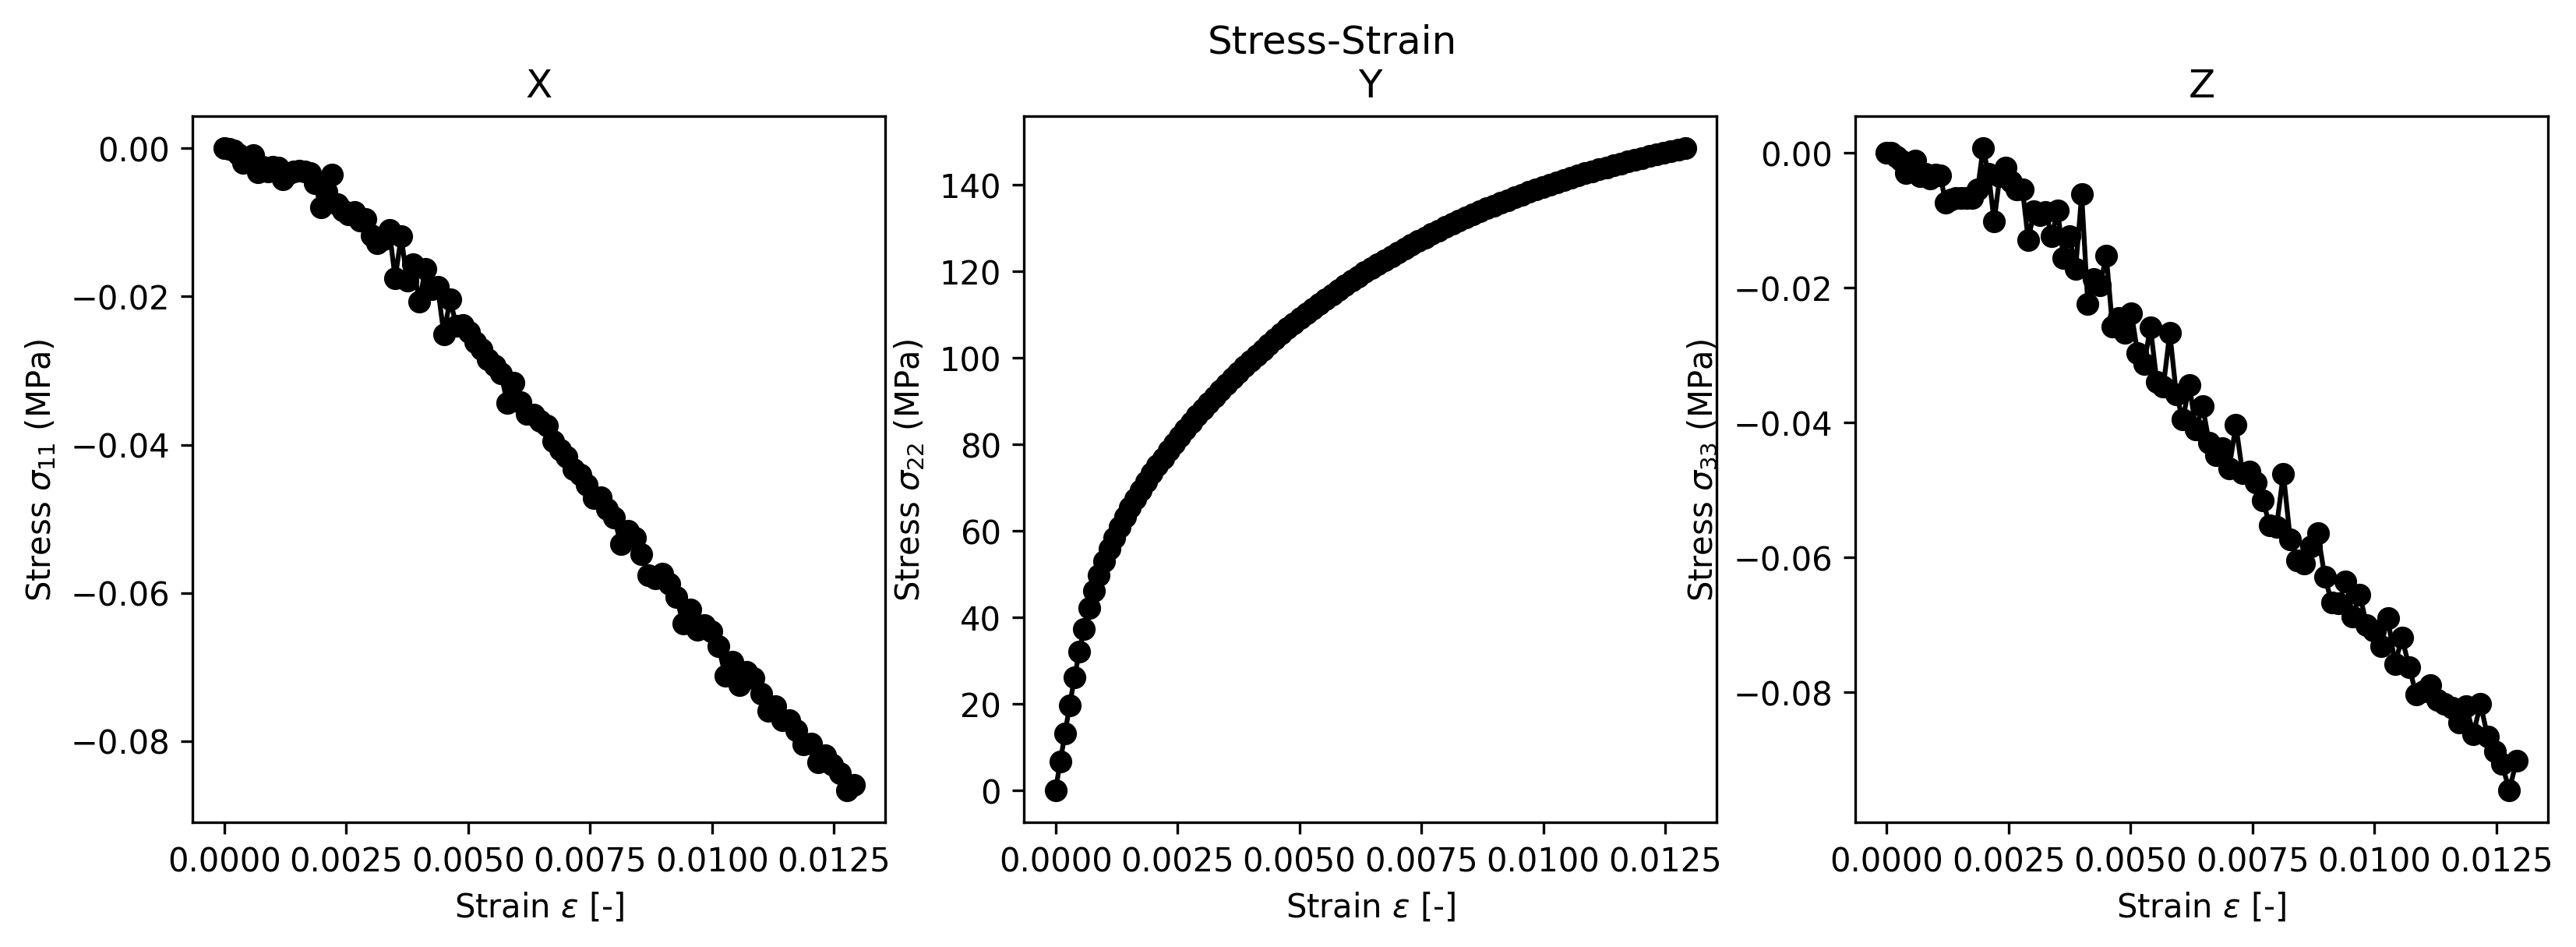

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300, facecolor='w')
fig.suptitle('Stress-Strain')

for i, axis in enumerate(["X", "Y", "Z"]): # loop over axes directions
    stress = ve_response["volume_data"]["sigma"]["data"][:, i, i]/1e6 # MPa
    strain = ve_response["volume_data"]["epsilon_V^0(F)_vM"]["data"]

    axs[i].plot(strain, stress, linestyle='solid', marker='o', color="k")
    axs[i].title.set_text(f"{axis}")
    axs[i].set_facecolor("white")
    axs[i].set_xlabel(f"Strain $\epsilon$ [-]")
    axs[i].set_ylabel(f"Stress $\sigma_{{{str(i+1)}{str(i+1)}}}$ (MPa)")

# Note: plots axes are labelled, but plots are not titled.
# this is so that the user may title their plot, and so that
# it may be easily combined with another plot.

---
## Calculate lattice strain from a matflow-DAMASK workflow
The following code takes a matflow workflow's `workflow.hdf5` file and plots true stress against lattice strain for each crystallographic plane.

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }
          opts: { add_Mises: true }

      volume_data: # For global stress-strain
        - field_name: sigma
          transforms: [mean_along_axes: 1] # mean over VE
          out_name: sigma
        - field_name: epsilon_V^0(F)_vM
          transforms: [mean_along_axes: 1] # mean over VE 
          out_name: epsilon_V^0(F)_vM
            
      field_data: # for lattice strain
        - field_name: phase
        - field_name: epsilon_V^2(F_e) # left elastic strain tensor
        - field_name: epsilon_U^2(F_e) # right elastic strain tensor
        - field_name: F_p # plastic deformation gradient tensor
        - field_name: O # orientations as quaternions

    base:
      phases:
        phase_1:
          mechanical:
            output: [F, F_e, F_p, P, L_p, O]
```

Step-by-step:
1. Import crystallographic parameters from crystallographic_params.yaml file.
2. Get unit vector describing the measurement direction given axis as string with function eg. "X" into "[1, 0, 0]"
3. Check for diffraction using tolerance of $5^o$ of satisfying Bragg condition.
4. Read lattice strains for these material points and add to bin for lattice plane label.
5. Plot lattice strains of each plane against true stress of the volume element.

Warning: This can take between up to 2hrs to compute for a $128^3$ volume element with $100$ loading steps.
**This is only required once.** Calculated data is saved to the workflow directory defined so that plot features can be changed quickly.

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pickle
from lattice_strain import lattice_strain
from utils import import_diff_params

phases = import_diff_params("Ti_alpha", "Ti_beta")
# define ve_response in workflow for stress and strain data...
ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response
true_stress = ve_response['volume_data']['sigma']['data'][:,1, 1]/1e6 # this is for Y axis. X would be [0, 0]

latticestrain={}
plane_intensity={}
for axis in ["X", "Y", "Z"]: # plot subsequent plots for every axis direction

    # calculate lattice strains and count material points with that lattice strain
    latticestrain[axis], plane_intensity[axis] = lattice_strain(workflow, phases, axis=axis, tol=10)
    
# save data to avoid re-running
with open(workflow_dir+'lattice_strain.pkl', 'wb') as ls:
    pickle.dump(latticestrain, ls)
ls.close()
with open(workflow_dir+'plane_intensity.pkl', 'wb') as pi:
    pickle.dump(plane_intensity, pi)
pi.close()

---
## plot true stress against lattice strain

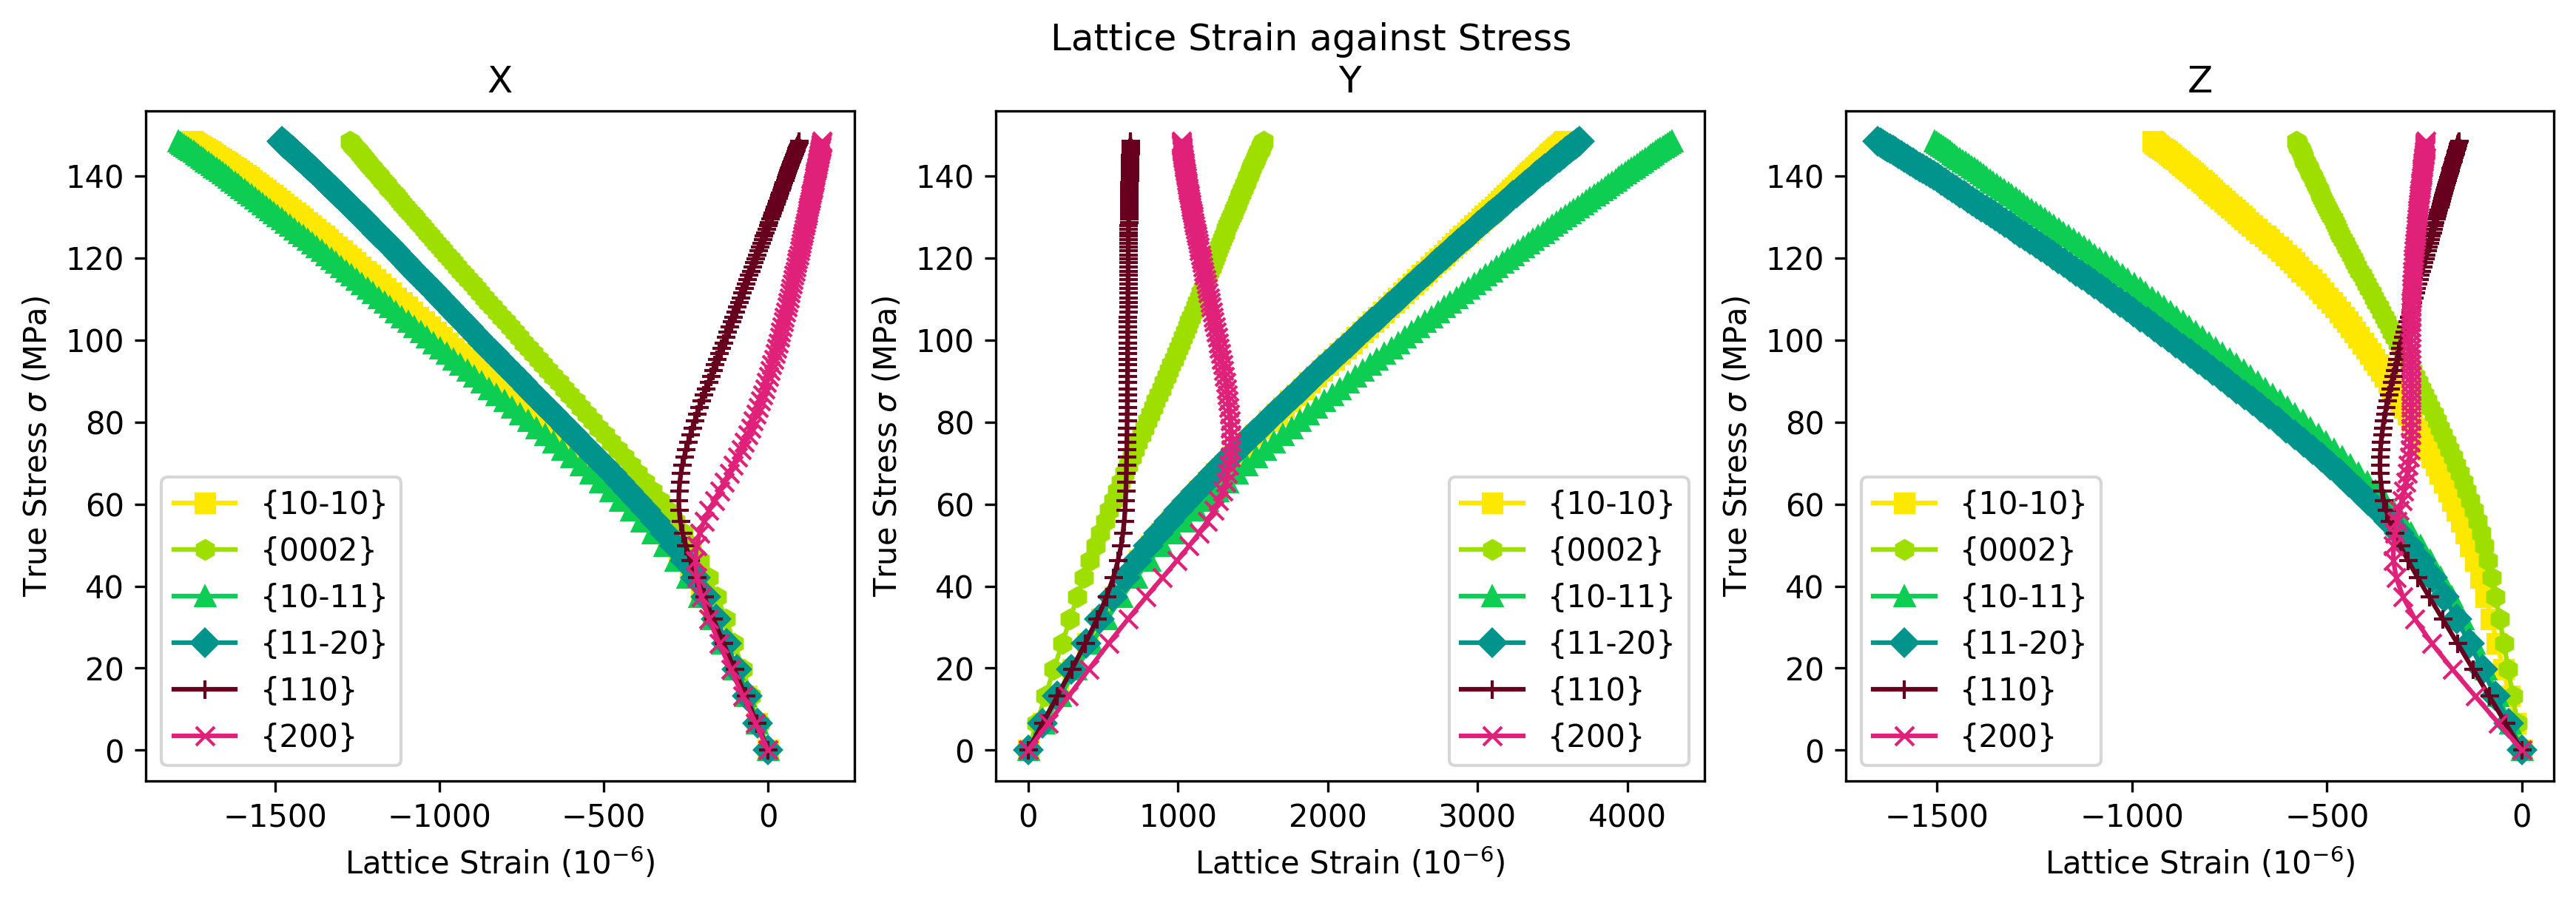

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pickle
from plotting import plot_latticestrain

latticestrain = pickle.load(open(workflow_dir+'lattice_strain.pkl', 'rb'))
true_stress = ve_response['volume_data']['sigma']['data'][:,1, 1]/1e6 # this is for Y axis. X would be [0, 0]

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle('Lattice Strain against Stress')
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_latticestrain(axs[i], true_stress, latticestrain, axis, incs="*", xlim=None, ylim=None)


## plot plane intensity against true strain

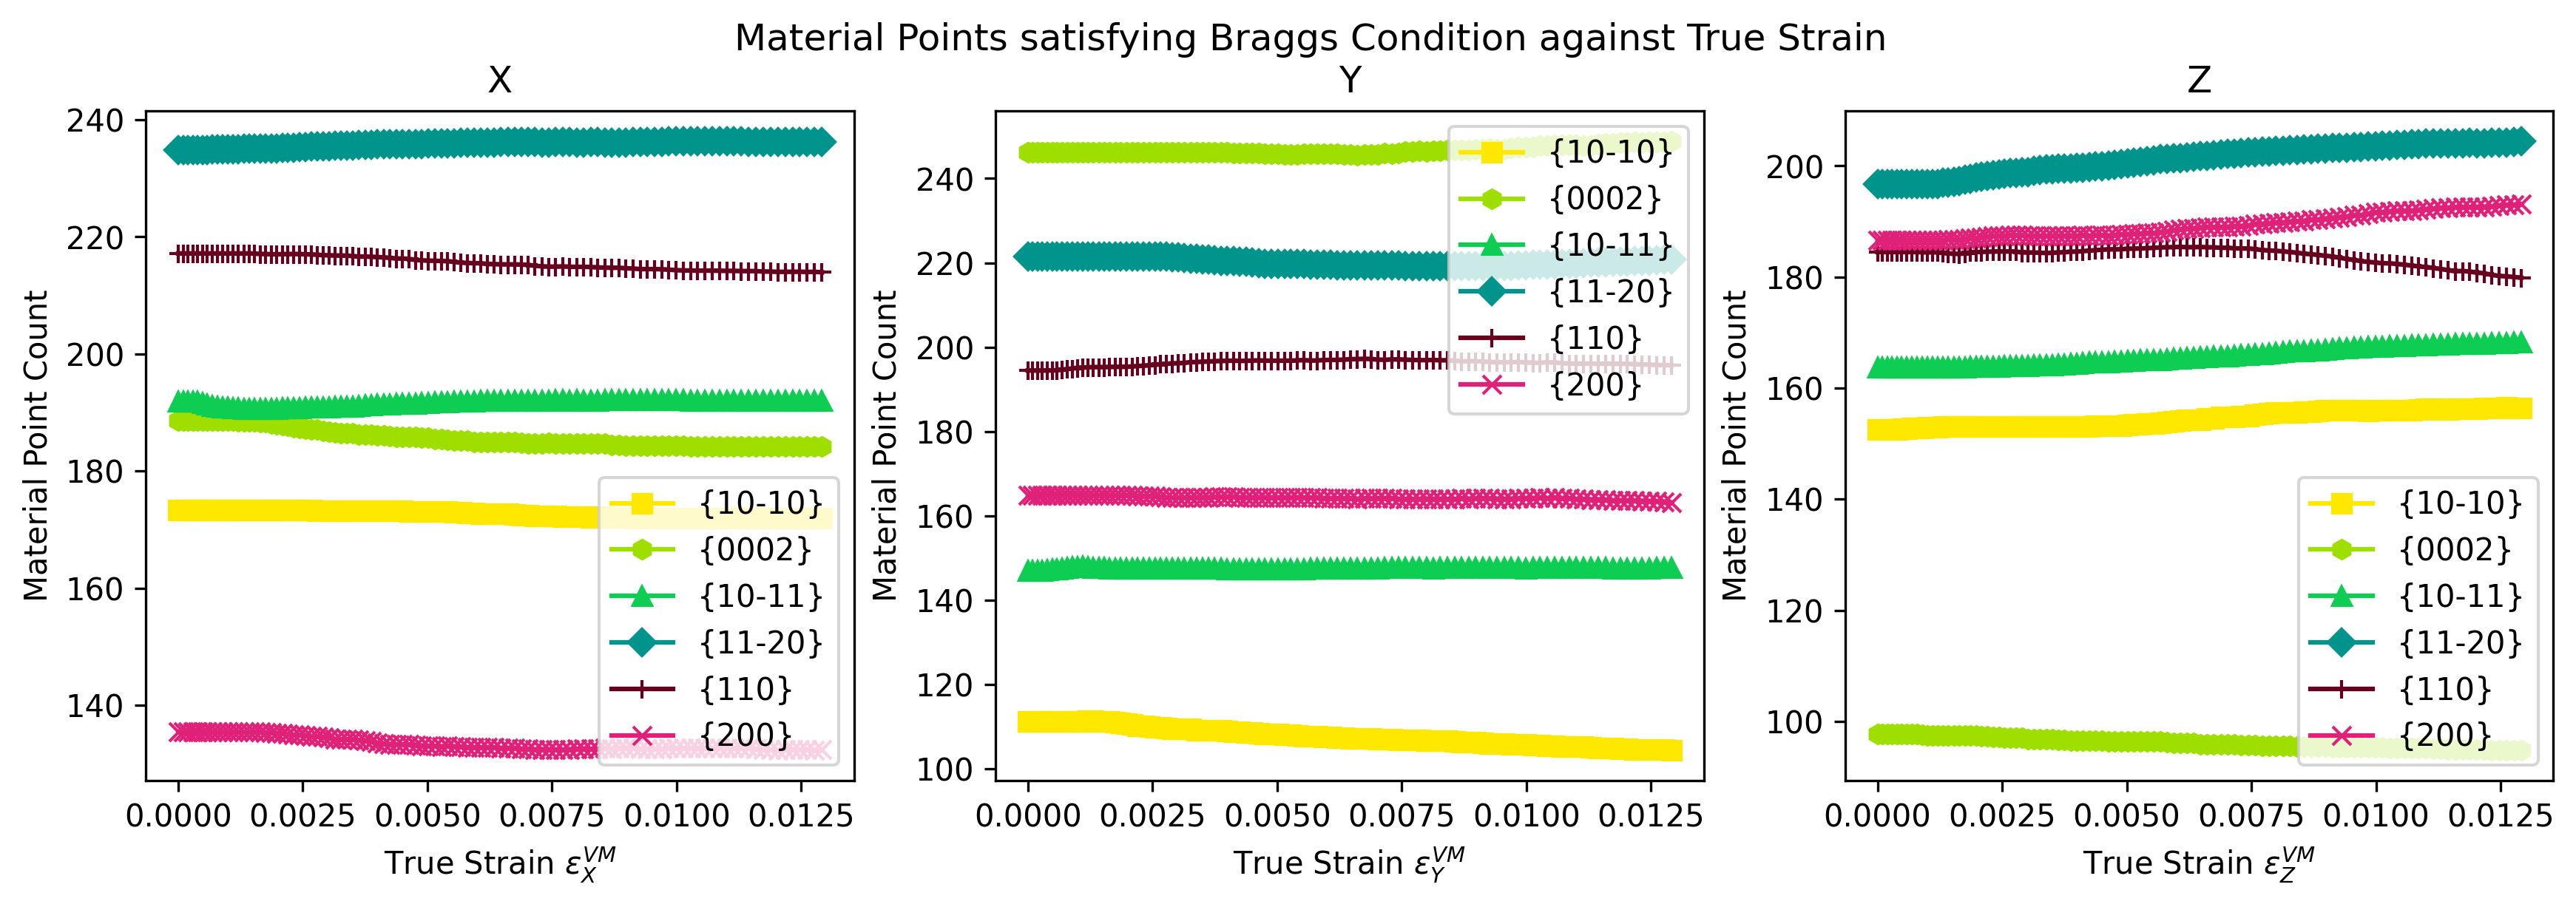

In [8]:
%matplotlib inline

from cycler import cycler
import pickle
from plotting import plot_truestrain_peakint
from utils import import_diff_params

phases = import_diff_params("Ti_alpha", "Ti_beta")
plane_intensity = pickle.load(open(workflow_dir+'plane_intensity.pkl', 'rb'))
true_strain = ve_response['volume_data']['epsilon_V^0(F)_vM']['data']

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle(f"Material Points satisfying Braggs Condition against True Strain")
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_truestrain_peakint(axs[i], plane_intensity, true_strain, axis, phases.keys(), xlim=None, ylim=None)


## plot distrubution of lattice strain

phase: Ti_beta Direction: X
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 
phase: Ti_beta Direction: Y
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 
phase: Ti_beta Direction: Z
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 


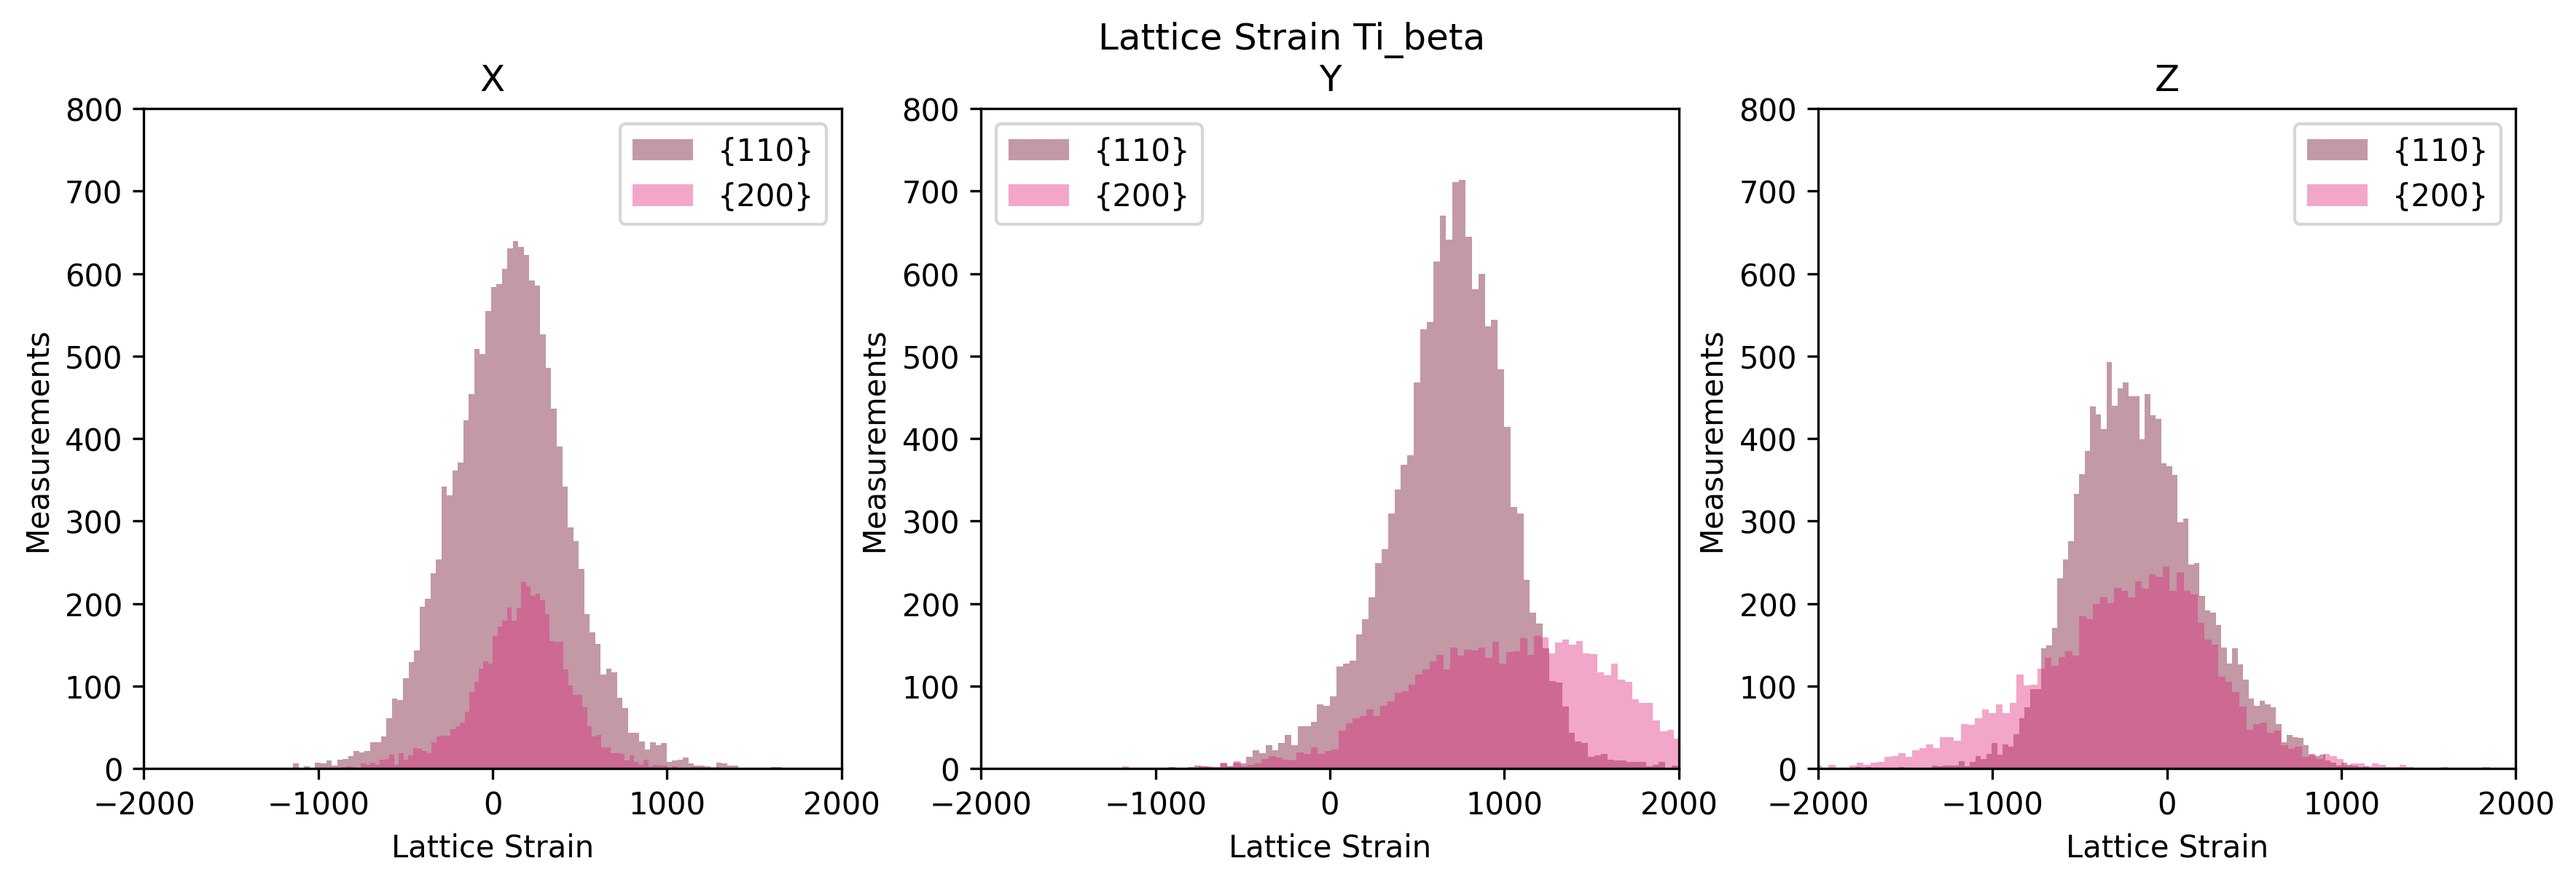

In [9]:
%matplotlib inline

import pickle
from plotting import plot_lattice_strain_dist_inc

latticestrain = pickle.load(open(workflow_dir+'lattice_strain.pkl', 'rb'))

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle(f"Lattice Strain Ti_beta")
for i, axis in enumerate(["X", "Y", "Z"]):
    plot_lattice_strain_dist_inc(axs[i], latticestrain, axis,
                                 phase="Ti_beta", inc=100, bins=100,
                                 xmin=-2000, xlim=2000,
                                 ymin=0, ylim=800)


## plot hydrostatic stress against true strain

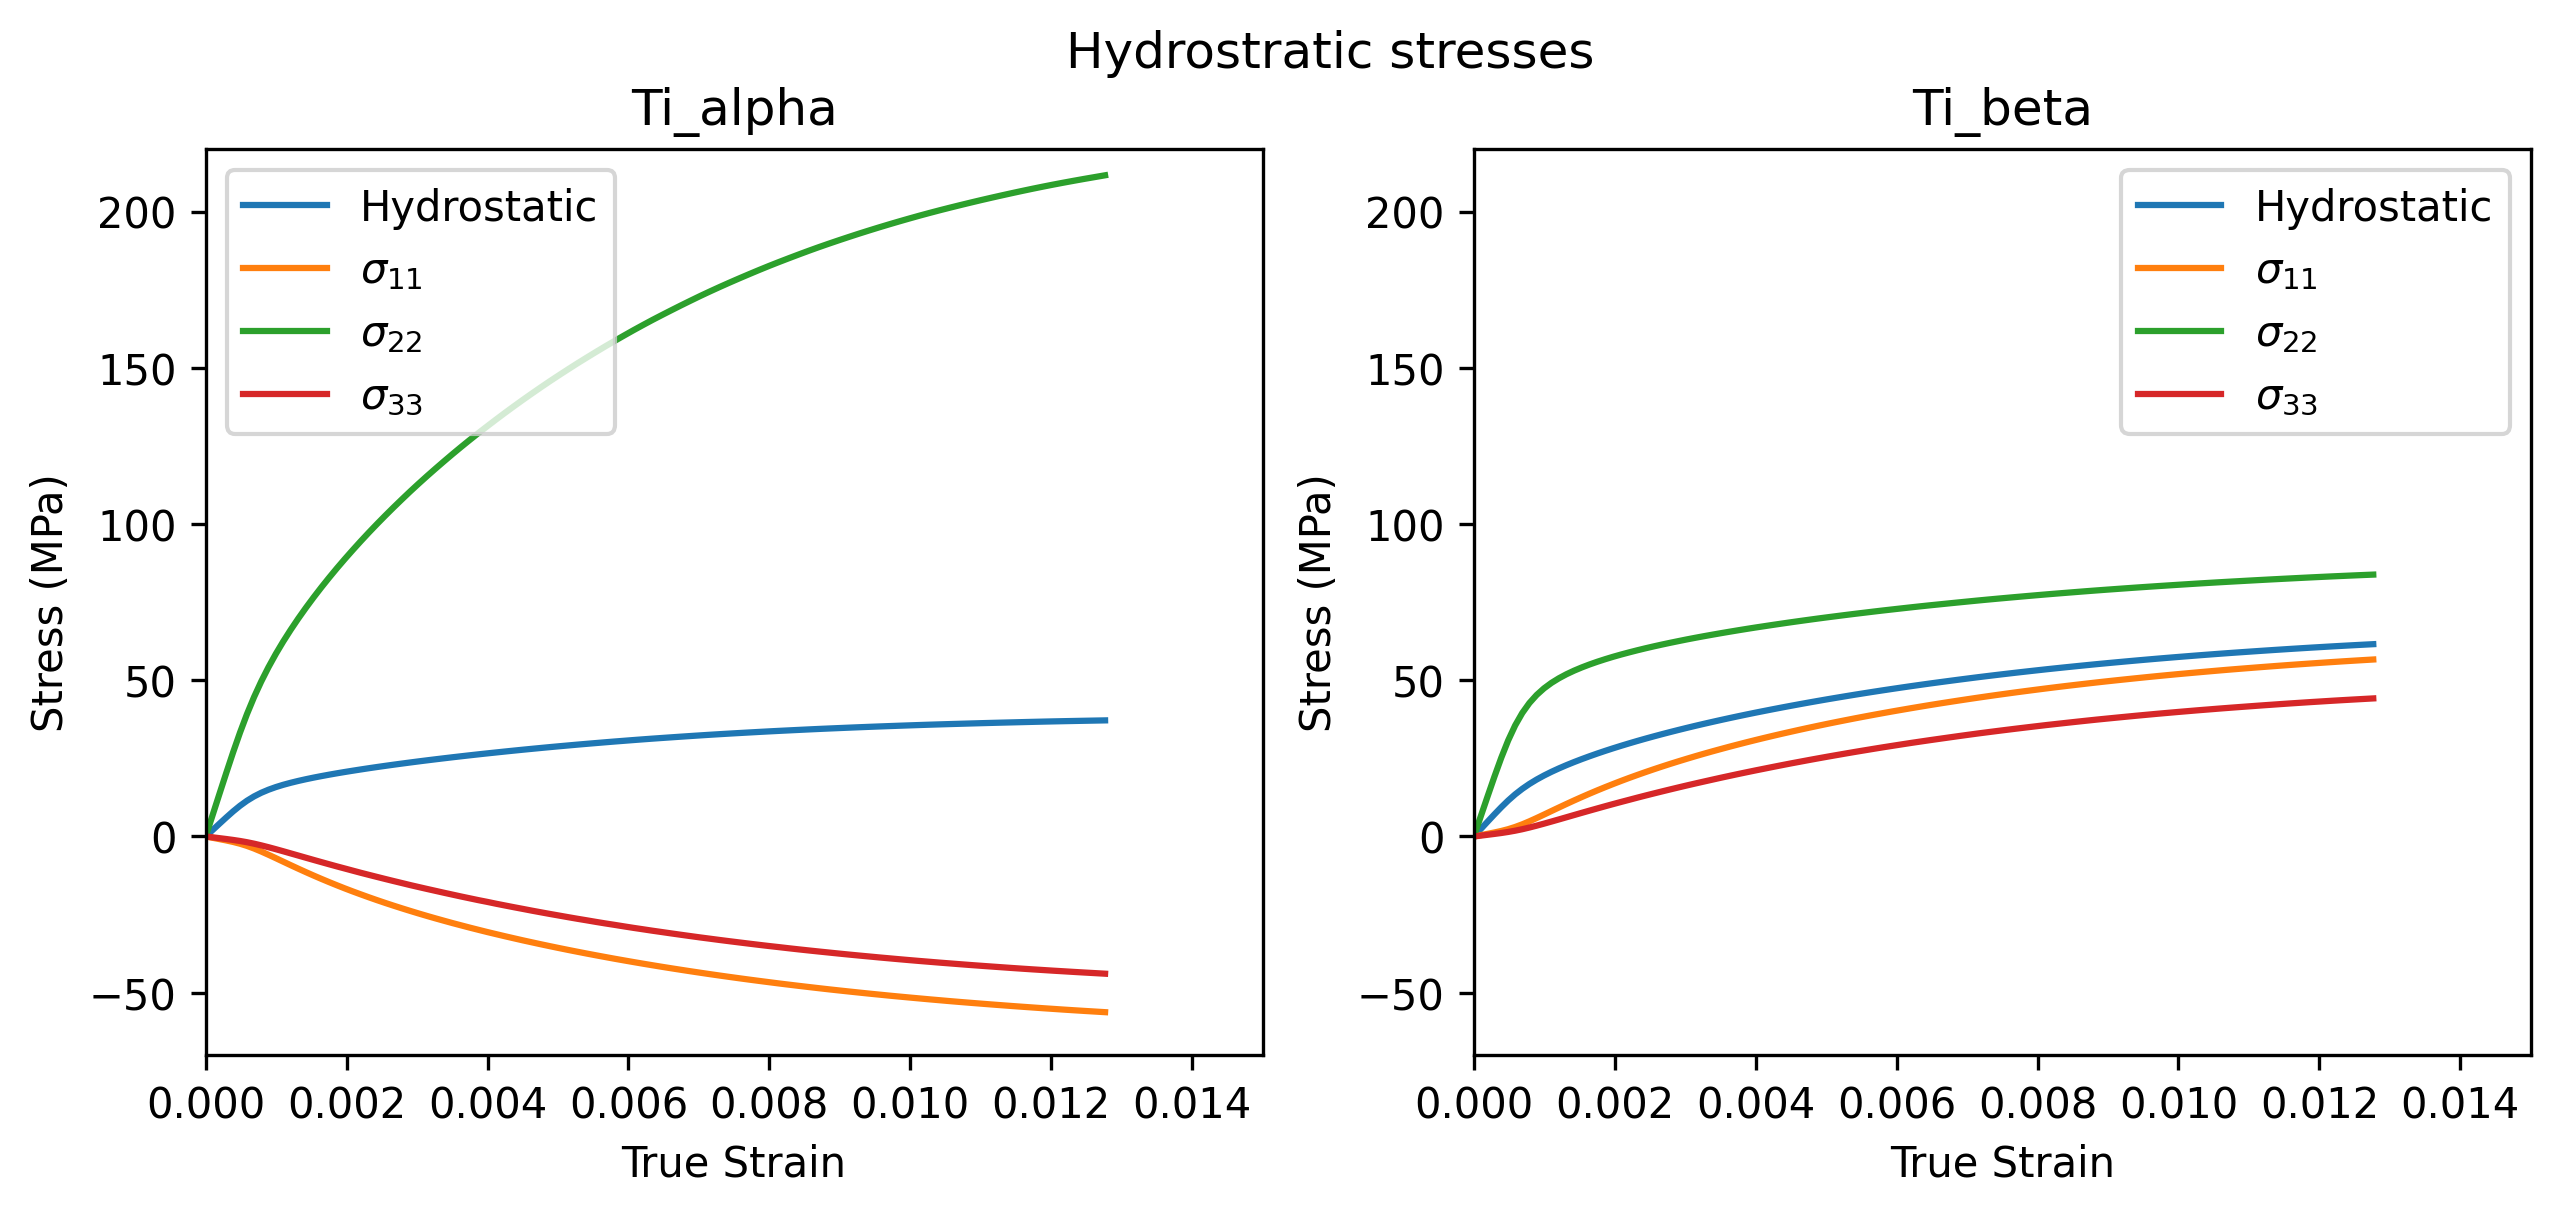

In [10]:
import numpy as np
import matplotlib.pyplot as plt
## plot hydrostatic strain with engineering strain

phases = ["Ti_alpha", "Ti_beta"]
phase="Ti_beta"
ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response
total_incs=range(0,100)
xmin, xlim = 0, 0.015
ymin, ylim = -70, 220

fig, axs = plt.subplots(1,2, figsize=(10, 4), dpi=300) # one row, three coloumns
fig.suptitle('Hydrostratic stresses')

for i, phase in enumerate(phases):
    true_strain = []
    sigma_X = []
    sigma_Y = []
    sigma_Z = []
    triaxial_stress = []

    # calculate hydrostatic stress from tensor components
    for inc in range(0, 100):
        true_strain.append(ve_response["volume_data"]['epsilon_V^0(F)_vM']['data'][inc])
        sigma_X.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,0,0].mean(axis=0)/1e6 )
        sigma_Y.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,1,1].mean(axis=0)/1e6 )
        sigma_Z.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,2,2].mean(axis=0)/1e6 )
        triaxial_stress.append( (sigma_X[inc] + sigma_Y[inc] + sigma_Z[inc])/3 )
    axs[i].plot(true_strain, triaxial_stress, label="Hydrostatic")
    axs[i].plot(true_strain, sigma_X, label="$\sigma_{11}$")
    axs[i].plot(true_strain, sigma_Y, label="$\sigma_{22}$")
    axs[i].plot(true_strain, sigma_Z, label="$\sigma_{33}$")
    axs[i].set_title(f"{phase}")
    axs[i].set_xlabel("True Strain")
    axs[i].set_xlim(xmin, xlim)
    axs[i].set_ylabel("Stress (MPa)")
    axs[i].set_ylim(ymin, ylim)
    axs[i].legend()